In [1]:
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup
from bs4 import Comment
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
import scipy.stats as st
import re
from openpyxl import load_workbook

### Create data frame with list of all NBA teams

In [2]:
html = urlopen('https://www.basketball-reference.com/teams/')
html_read = html.read()
bsObj = BeautifulSoup(html_read)

team_abbrev = []
team_name = []
for child in bsObj.find('tbody').children:
    try:
        team_url = child.find('a').get('href')
        team = re.split('/', team_url)[2]
        team_abbrev.append(team)
        
        name = child.find('th').get_text()
        team_name.append(name)
    except:
        pass
    
df_teams = pd.DataFrame({'team':team_abbrev, 'name':team_name})

# fix abbreviation for teams with new abbreviations in 2021 season
df_teams.iloc[2][0] = 'BRK'
df_teams.iloc[18][0] = 'NOP'
df_teams.iloc[3][0] = 'CHO'

df_teams.to_csv('df_teams.csv')

### create data frame with list of all players on 2021 NBA rosters

In [3]:
df_players = pd.DataFrame(columns = ['team_name', 'team_code', 'player_name', 'player_code'])
codes = []
names = []
for i in range(len(df_teams)):
    team = df_teams.iloc[i,0]
    name = df_teams.iloc[i,1]
    team_url = urlopen('https://www.basketball-reference.com/teams/' + team + '/2021.html')
    bsObj = BeautifulSoup(team_url.read())
    for child in bsObj.find('tbody').children:
        try:
            player_url = child.find('a').get('href')            
            player_name = child.find('a').get_text()  
            player_url = re.split('\.', player_url)[0]
            player_code = re.split('/', player_url)[3]
            player_code = '/' + player_code[0] + '/' + player_code
            codes.append(player_code)
            names.append(player_name)
        except:
            pass
    df_team = pd.DataFrame(zip([name] * len(codes), [team] * len(codes), names, codes), 
                           columns=['team_name', 'team_code', 'player_name', 'player_code'])
    df_players = pd.concat([df_players, df_team], join='outer')
    codes = []
    names = []

df_players = df_players.reset_index(drop=True)

# brazdig01 is repeated twice so delete one of them (also the link doesnt work so delete both)
df_players.drop(labels=371, inplace=True)
df_players.drop(labels=372, inplace=True)

df_players.to_csv('df_players.csv')

df_players.head()

,team_name,team_code,player_name,player_code
0,Atlanta Hawks,ATL,Solomon Hill,/h/hillso01
1,Atlanta Hawks,ATL,Kevin Huerter,/h/huertke01
2,Atlanta Hawks,ATL,Trae Young,/y/youngtr01
3,Atlanta Hawks,ATL,John Collins,/c/collijo01
4,Atlanta Hawks,ATL,Clint Capela,/c/capelca01


# Web scrape player data from basketballreference.com
- the following cell only needs to be run once to collect data from previous months then save to csv
- then, run the next cell daily to retrieve data on previous day's games (by retrieving current month's data)

In [4]:
def get_stats_month(month, df_stats_1, df_stats_2, df_stats_3, df_stats_4):
    columns_basic = ['player_name', 'min', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
                     'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-', 'team_name', 'opp_name', 'home', 'date',
                     'team_abbrev', 'team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg',
                     'opp_abbrev', 'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg'
                    ]
    columns_advanced = ['player_name', 'min', 'TS%', 'eFG%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%',
                        'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM', 'team_name', 'opp_name', 'home', 'date'
                       ]   
    month_url = urlopen('https://www.basketball-reference.com/leagues/NBA_2021_games-{}.html'.format(month))
    month_bsObj = BeautifulSoup(month_url.read())
    for game in month_bsObj.find('tbody').children:
        try:
            date = game.find('th').get_text()
            date = pd.to_datetime(date)
            
            team1 = game.find_all('td')[1].get_text()
            team2 = game.find_all('td')[3].get_text()
            
            box_score_url = game.find_all('a')[3].get('href')
            box_score_url = urlopen('https://www.basketball-reference.com{}'.format(box_score_url))
            box_score_bsObj = BeautifulSoup(box_score_url.read())
            
            ###### Four factors for teams
            four_factors = box_score_bsObj.find('div', attrs={'id': ['all_four_factors']})
            for comment in four_factors(text=lambda text: isinstance(text, Comment)):
                comment = BeautifulSoup(comment, 'html.parser')
                team1_stats = []
                team2_stats = []
                flag=0
                table = comment.find('tbody')
                for team in table.children:
                    try:
                        for stat in team.children:
                            if flag == 0:
                                team1_stats.append(stat.get_text())
                            else:
                                team2_stats.append(stat.get_text())
                        flag = 1
                    except:
                        pass
            
            ###### There are four tables of interest for players
            divs = box_score_bsObj.find_all('div', attrs={'class':'table_container'})
            caption = ''
            for div in divs:
                try:
                    prev_caption = caption
                    caption = div.caption.get_text()
                    # One
                    if re.search('{} \([0-9]'.format(team1), caption):
                        table = div.find('tbody')
                        for child in table.children:
                            try:
                                stats = []
                                for stat in child.children:
                                    stats.append(stat.get_text())
                                stats.append(team1)
                                stats.append(team2)
                                stats.append(0)
                                stats.append(date)
                                stats = np.concatenate([stats, team1_stats, team2_stats])
                                df_stats_1 = df_stats_1.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns = columns_basic))
                            except:
                                pass
                
                    # Two
                    if re.search('{} \([0-9]'.format(team2), caption):
                        table = div.find('tbody')
                        for child in table.children:
                            try:
                                stats = []
                                for stat in child.children:
                                    stats.append(stat.get_text())
                                stats.append(team2)
                                stats.append(team1)
                                stats.append(1)
                                stats.append(date)
                                stats = np.concatenate([stats, team2_stats, team1_stats])
                                df_stats_2 = df_stats_2.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns = columns_basic))
                            except:
                                pass
                    
                    # Three
                    if re.search('^ Table$', caption) and (team1 in prev_caption):
                        table = div.find('tbody')
                        for child in table.children:
                            try:
                                stats = []
                                for stat in child.children:
                                    stats.append(stat.get_text())
                                stats.append(team1)
                                stats.append(team2)
                                stats.append(0)
                                stats.append(date)
                                df_stats_3 = df_stats_3.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns = columns_advanced))
                            except:
                                pass
                
                    # Four
                    if re.search('^ Table$', caption) and (team2 in prev_caption):
                        table = div.find('tbody')
                        for child in table.children:
                            try:
                                stats = []
                                for stat in child.children:
                                    stats.append(stat.get_text())
                                stats.append(team2)
                                stats.append(team1)
                                stats.append(1)
                                stats.append(date)
                                df_stats_4 = df_stats_4.append(pd.DataFrame(np.array(stats).reshape(1,-1), columns = columns_advanced)) 
                            except:
                                pass
                except:
                    pass
        except:
            pass
    
    return df_stats_1, df_stats_2, df_stats_3, df_stats_4


#######################################################################################
months = ['december', 'january', 'february', 'march', 'april']
df_stats_1 = pd.DataFrame()
df_stats_2 = pd.DataFrame()
df_stats_3 = pd.DataFrame()
df_stats_4 = pd.DataFrame()

for month in months:
    df_stats_1, df_stats_2, df_stats_3, df_stats_4 = get_stats_month(month, df_stats_1, df_stats_2, df_stats_3, df_stats_4)
    print(month)

df_stats_1.to_csv('df_stats_1.csv')
df_stats_2.to_csv('df_stats_2.csv')
df_stats_3.to_csv('df_stats_3.csv')
df_stats_4.to_csv('df_stats_4.csv')

december
january
february
march
april


# Run code for current month

In [5]:
# since it is currently May, games are added to to the website on May each day so re-run this code daily
# when it switches to June, add May to the previous cell and run this cell for June
df_stats_1 = pd.read_csv('df_stats_1.csv', index_col=0)
df_stats_2 = pd.read_csv('df_stats_2.csv', index_col=0)
df_stats_3 = pd.read_csv('df_stats_3.csv', index_col=0)
df_stats_4 = pd.read_csv('df_stats_4.csv', index_col=0)

MONTH = 'may'

df_stats_1, df_stats_2, df_stats_3, df_stats_4 = get_stats_month(MONTH, df_stats_1, df_stats_2, df_stats_3, df_stats_4)

# Merge data frames

In [7]:
df_stats_basic = pd.concat([df_stats_1, df_stats_2])
df_stats_advanced = pd.concat([df_stats_3, df_stats_4])

df_stats = pd.merge(df_stats_basic, df_stats_advanced, how='inner', 
                    on=['player_name', 'min', 'team_name', 'opp_name', 'home', 'date'])

# get rid of unnecessary columns
df_stats.drop(columns=['FG%', '3P%', 'FT%', 'TRB'], inplace=True)
                        
df_stats.head()

,player_name,min,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,Andrew Wiggins,31:14,4,16,2,6,3,4,0,2,...,6.5,3,5,0,2.7,18.4,26.3,63,118,-14
1,Stephen Curry,30:19,7,21,2,10,4,4,3,1,...,3.4,6.1,61.1,2.9,0,11.6,32.1,99,114,6
2,Kelly Oubre,25:39,3,14,0,6,0,0,4,3,...,11.9,12.6,11.9,1.7,6.6,17.6,25,54,110,-11
3,James Wiseman,24:17,7,13,1,1,4,8,1,5,...,21,11.4,0,3.6,0,5.7,27.2,107,107,3.3
4,Eric Paschall,21:33,2,6,1,1,1,2,1,0,...,0,2.1,0,0,3.9,0,12.1,96,119,-6.9


# Data Cleaning

In [8]:
df_clean = df_stats.copy()

# convert columns with numbers to numeric type
numeric_columns = ['FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'ORB','DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '+/-',
                   'home', 'team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg','opp_Pace', 
                   'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg', 'TS%', 'eFG%', '3PAr', 'FTr', 'ORB%', 
                   'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM']
for column in numeric_columns:
    df_clean[column] = pd.to_numeric(df_clean[column])

# convert min from string to numeric
def min_to_numeric(value):
    minute = int(re.split(':', value)[0])
    second = int(re.split(':', value)[1])
    return minute + round(second / 60, 2)
df_clean['min'] = df_clean['min'].apply(lambda x: min_to_numeric(x))

# convert date to datetime
df_clean['date'] = pd.to_datetime(df_clean['date'])

# only consider players who played for at least 25 min
# I am not interested in making predictions for low-scoring players
df_clean = df_clean[df_clean['min'] >= 25]

df_clean.head()

,player_name,min,FG,FGA,3P,3PA,FT,FTA,ORB,DRB,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,Andrew Wiggins,31.23,4,16,2,6,3,4,0,2,...,6.5,3.0,5.0,0.0,2.7,18.4,26.3,63.0,118.0,-14.0
1,Stephen Curry,30.32,7,21,2,10,4,4,3,1,...,3.4,6.1,61.1,2.9,0.0,11.6,32.1,99.0,114.0,6.0
2,Kelly Oubre,25.65,3,14,0,6,0,0,4,3,...,11.9,12.6,11.9,1.7,6.6,17.6,25.0,54.0,110.0,-11.0
13,Paul George,35.77,13,18,5,8,2,2,0,6,...,21.8,9.5,15.2,1.3,0.0,20.9,27.3,131.0,107.0,10.9
14,Kawhi Leonard,34.02,10,26,1,8,5,5,0,2,...,7.6,3.3,14.2,2.7,0.0,9.6,37.5,93.0,106.0,-5.6


# Create dataset with following data:
- player stats averaged over season up until game of interest
- player stats averaged over the last week
- team/opp stats averaged over season up until game of interest
- team/opp stats averaged over the last week


In [9]:
df_final = df_clean[['player_name', 'team_name', 'opp_name', 'home', 'date', 'PTS']].copy()

# only consider games starting in January so that we have at least a week of games already played
df_final = df_final[df_final['date'] >= pd.to_datetime('2021-01-01')]

# add player stats averaged over the last week
def player_week(row):
    player = row['player_name']
    team = row['team_name']
    date = row['date']
    df_player = df_clean[df_clean['player_name'] == player]
    df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
    if len(df_player_week) == 0:
        col = df_player.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).columns
        AVGs = pd.Series(np.zeros(len(df_stats.columns) - 6), index=col)
    else:
        AVGs = df_player_week.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).mean()
    return AVGs

def player_season(row):
    player = row['player_name']
    team = row['team_name']
    date = row['date']
    df_player = df_clean[df_clean['player_name'] == player]
    df_player_season = df_player[df_player['date'] < date]
    if len(df_player_season) == 0:
        col = df_player.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).columns
        AVGs = pd.Series(np.zeros(len(df_stats.columns) - 6), index=col)
    else:
        AVGs = df_player_season.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).mean()
    return AVGs

def opp_week(row):
    player = row['player_name']
    opp = row['opp_name']
    date = row['date']
    df_opp = df_clean[df_clean['team_name'] == opp]
    df_opp = df_opp[['date','team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg', 
                     'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg']]
    df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
    if len(df_opp_week) == 0:
        col = df_opp_week.drop(columns=['date']).columns
        AVGs = pd.Series(np.zeros(len(df_opp.columns) - 1), index=col)
    else:
        df_opp_week = df_opp_week.groupby(by='date').agg(np.mean)
        AVGs = df_opp_week.mean()
    return AVGs
        
def opp_season(row):
    player = row['player_name']
    opp = row['opp_name']
    date = row['date']
    df_opp = df_clean[df_clean['team_name'] == opp]
    df_opp = df_opp[['date','team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg', 
                     'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg']]
    df_opp_season = df_opp[df_opp['date'] < date]
    if len(df_opp_season) == 0:
        col = df_opp_season.drop(columns=['date']).columns
        AVGs = pd.Series(np.zeros(len(df_opp.columns) - 1), index=col)
    else:
        df_opp_season = df_opp_season.groupby(by='date').agg(np.mean)
        AVGs = df_opp_season.mean()
    return AVGs
    
df_player_week = df_final.apply(lambda x: player_week(x), axis=1)
df_player_season = df_final.apply(lambda x: player_season(x), axis=1)
df_opp_week = df_final.apply(lambda x: opp_week(x), axis=1)
df_opp_season = df_final.apply(lambda x: opp_week(x), axis=1)

df_final = pd.merge(df_final, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_player_week_AVG'))
df_final = pd.merge(df_final, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_player_season_AVG'))
df_final = pd.merge(df_final, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_opp_week_AVG'))
df_final = pd.merge(df_final, df_opp_season, how='inner', left_index=True, right_index=True, suffixes=('','_opp_season_AVG'))

df_final.head()

,player_name,team_name,opp_name,home,date,PTS,min,FG,FGA,3P,...,team_TOV%_opp_season_AVG,team_ORB%_opp_season_AVG,team_FT/FG_opp_season_AVG,team_ORtg_opp_season_AVG,opp_Pace_opp_season_AVG,opp_eFG%_opp_season_AVG,opp_TOV%_opp_season_AVG,opp_ORB%_opp_season_AVG,opp_FT/FG_opp_season_AVG,opp_ORtg_opp_season_AVG
746,Brandon Clarke,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,15,27.410000,5.000000,12.000000,0.500000,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5
747,Kyle Anderson,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,18,33.756667,6.666667,14.333333,2.000000,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5
748,Tyus Jones,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,6,34.720000,4.000000,12.000000,0.000000,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5
749,Dillon Brooks,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,21,31.253333,7.666667,20.000000,2.333333,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5
750,Jonas Valančiūnas,Memphis Grizzlies,Charlotte Hornets,0,2021-01-01,14,34.025000,4.000000,8.500000,0.500000,...,13.666667,26.166667,0.173667,107.766667,102.433333,0.500333,14.366667,19.9,0.213667,101.5


### Get rid of rows with lots of 0s
- player was likely coming off injury, which might skew predictions unnecessarily
- could also represent game right after all-star break where game had not been played in over a week

In [10]:
def number_zeroes(row):
    values = row.values
    flag = 0
    for value in values:
        if value == 0:
            flag += 1
    if flag > 20:
        return 1
    else:
        return 0

mask = df_final.apply(lambda x: number_zeroes(x), axis=1)
mask = mask.values
mask = mask == 0

df_final = df_final.iloc[mask]

### get rid of rows where points scored = 0 
- player likely was injured and did not play

In [11]:
df_final = df_final[df_final['PTS'] > 0]

# Model Development

In [12]:
# drop non-numeric columns
df_model = df_final.drop(columns=['player_name', 'team_name', 'opp_name', 'date'], axis=1)

In [13]:
y = df_model['PTS']
X = df_model.drop(columns=['PTS'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

### Random Forests

In [23]:
tree = RandomForestRegressor(random_state=0)

params = {'n_estimators': [100, 200],
          'max_depth': [15, 20],
          'max_features': [5, 10, 20]
         }

#grid_tree = GridSearchCV(tree, param_grid=params, scoring='r2', cv=3)
#grid_tree.fit(X_train, y_train)
#print('Best RF params: {}'.format(grid_tree.best_estimator_))

Best RF params: RandomForestRegressor(max_depth=15, max_features=5, n_estimators=200)


RF score: 0.4088106058718258


Text(0.5, 1.0, 'Predicted vs. Actual Points Scored using RF model')

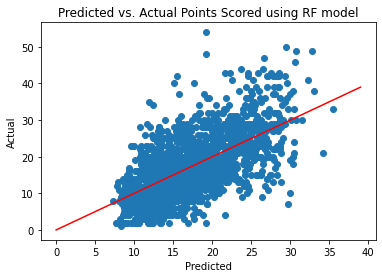

In [35]:
tree = RandomForestRegressor(max_depth=15, max_features=5, n_estimators=200, random_state=0)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_score_tree = tree.score(X_test,y_test)
print('RF score: {}'.format(y_score_tree))
_ = plt.scatter(y_pred_tree, y_test)
_ = plt.plot(np.arange(40), np.arange(40),'r')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs. Actual Points Scored using RF model')

In [227]:
pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)[:20]

PTS_player_season_AVG     0.061903
FG_player_season_AVG      0.055663
USG%_player_season_AVG    0.052926
FGA_player_season_AVG     0.051587
USG%                      0.039027
FGA                       0.033802
PTS_player_week_AVG       0.032155
FT_player_season_AVG      0.030669
FTA_player_season_AVG     0.023758
min_player_season_AVG     0.020103
TOV_player_season_AVG     0.019686
FG                        0.019672
FTA                       0.011636
FT                        0.010773
AST%_player_season_AVG    0.010543
min                       0.010374
AST_player_season_AVG     0.009262
BPM_player_season_AVG     0.007717
TOV                       0.007653
3PA_player_season_AVG     0.007490
dtype: float64

### Lasso/Ridge

In [16]:
ridge = Ridge()
lasso = Lasso(max_iter=100000)
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_ridge = GridSearchCV(ridge, param_grid=params, scoring='r2', cv=5)
grid_lasso = GridSearchCV(lasso, param_grid=params, scoring='r2', cv=5)

#grid_ridge.fit(X_train, y_train)
#grid_lasso.fit(X_train, y_train)

#print('Best ridge params: {}'.format(grid_ridge.best_estimator_))
#print('Best lasso params: {}'.format(grid_lasso.best_estimator_))

Best ridge params: Ridge(alpha=1000)
Best lasso params: Lasso(alpha=0.1, max_iter=100000)


In [19]:
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
y_score_ridge = ridge.score(X_test,y_test)
print('ridge score: {}'.format(y_score_ridge))

lasso = Lasso(alpha=0.1, max_iter=100000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
y_score_lasso = lasso.score(X_test,y_test)
print('lasso score: {}'.format(y_score_lasso))

ridge score: 0.4044941963194403
lasso score: 0.4047827329381949


### Voting Regressor

Voting Regressor score: 0.41125745926938606


Text(0, 0.5, 'Actual')

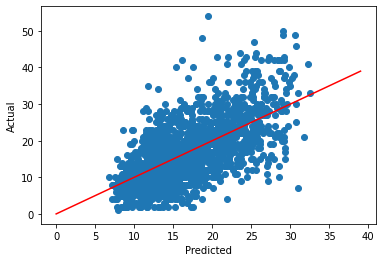

In [37]:
vote = VotingRegressor([('Ridge',ridge), ('Lasso',lasso), ('RF',tree)], n_jobs=-1)
vote.fit(X_train, y_train)
print('Voting Regressor score: {}'.format(vote.score(X_test, y_test)))
y_pred_vote = vote.predict(X_test)
_ = plt.scatter(y_pred_vote, y_test)
_ = plt.plot(np.arange(40), np.arange(40), 'r')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Determine mean, standard deviation of normal distribution of the difference between predicted and actual points scored on the test set

Median: -0.46330536228115804
Mean: -0.09779963698034397
Standard Deviation: 6.553806503413752


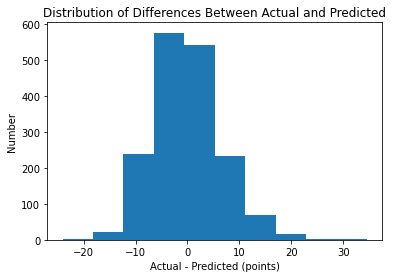

In [38]:
y_diff = y_test - y_pred_vote
_ = plt.hist(y_diff)
plt.xlabel('Actual - Predicted (points)')
plt.ylabel('Number')
plt.title('Distribution of Differences Between Actual and Predicted')

std = st.stats.tstd(y_diff)
mean = np.mean(y_diff)
median = np.median(y_diff)
print('Median: {}'.format(median))
print('Mean: {}'.format(mean))
print('Standard Deviation: {}'.format(std))

# Create data to predict during NBA playoffs
- this function will take information about a player for a particular game and output a prediction using the second model to compare to a over/under generated by a betting site

In [42]:
def predict_player_points(player, team, opp, home, date):
    X_predict = pd.DataFrame(np.array([date, team, home, opp]).reshape(1,-1), columns = ['date', 'team', 'home', 'opp'])
    
    # add player stats averaged over the last week
    df_player = df_clean[df_clean['player_name'] == player]
    df_player_week = df_player[(df_player['date'] < date) & (df_player['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_player_week = df_player_week.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).mean()
    df_player_week = pd.DataFrame(np.array(df_player_week).reshape(1,-1), columns = df_player_week.index)
    
    
    # add player stats averaged over the season
    df_player_season = df_player[df_player['date'] < date]
    df_player_season = df_player_season.drop(columns=['player_name','date','team_name','opp_name', 'team_abbrev', 'opp_abbrev']).mean()
    df_player_season = pd.DataFrame(np.array(df_player_season).reshape(1,-1), columns = df_player_season.index)
    
    # add opponent stats averaged over the last week
    df_opp = df_clean[df_clean['team_name'] == opp]
    df_opp = df_opp[['date','team_Pace', 'team_eFG%', 'team_TOV%', 'team_ORB%', 'team_FT/FG', 'team_ORtg', 
                     'opp_Pace', 'opp_eFG%', 'opp_TOV%', 'opp_ORB%', 'opp_FT/FG', 'opp_ORtg']]
    df_opp_week = df_opp[(df_opp['date'] < date) & (df_opp['date'] >= date - pd.to_timedelta(1, unit='W'))]
    df_opp_week = df_opp_week.groupby(by='date').agg(np.mean)
    df_opp_week = df_opp_week.mean()
    df_opp_week = pd.DataFrame(np.array(df_opp_week).reshape(1,-1), columns = df_opp_week.index)
        
    # add opponent stats averaged over the season
    df_opp_season = df_opp[df_opp['date'] < date]
    df_opp_season = df_opp_season.groupby(by='date').agg(np.mean)
    df_opp_season = df_opp_season.mean()
    df_opp_season = pd.DataFrame(np.array(df_opp_season).reshape(1,-1), columns = df_opp_season.index)

    # merge all three df's
    X_predict = pd.merge(X_predict, df_player_week, how='inner', left_index=True, right_index=True, suffixes=('','_player_week_AVG'))
    X_predict = pd.merge(X_predict, df_player_season, how='inner', left_index=True, right_index=True, suffixes=('','_player_season_AVG'))
    X_predict = pd.merge(X_predict, df_opp_week, how='inner', left_index=True, right_index=True, suffixes=('','_opp_week_AVG'))
    X_predict = pd.merge(X_predict, df_opp_season, how='inner', left_index=True, right_index=True, suffixes=('','_opp_season_AVG'))
    # drop team and opp
    X_predict.drop(columns=['date','team','opp'], axis=1, inplace=True)

    for col in X_predict.columns:
        if X_predict[col].isnull().sum() == len(X_predict):
            X_predict.drop(columns=[col], axis=1, inplace=True)
            
    X_predict = scale.transform(X_predict)
    y_pred = np.round(vote.predict(X_predict), 1)
    return y_pred[0]
    

# Main
### enter game info and write all data to excel file

In [59]:
# enter game info
name1 = 'Bradley Beal'  # home player
OU1 = 30.5
name2 = 'Domantas Sabonis' # road player
OU2 = 24.5

playoff_round = 0
game = 1
bet_id = 2

date = pd.to_datetime('today').normalize()

########
team1 = df_players[df_players['player_name'] == name1]['team_name'].values[0]
team2 = df_players[df_players['player_name'] == name2]['team_name'].values[0]

pred1 = predict_player_points(name1, team1, team2, 1, date)
pred2 = predict_player_points(name2, team2, team1, 0, date)

diff1 = OU1 - pred1
diff2 = OU2 - pred2

####### determine probability of success for bets on first model
if diff1 > 0:
    p1 = st.norm(mean,std).cdf(diff1)
else:
    p1 = 1 - st.norm(mean,std).cdf(diff1)
    
if diff2 > 0:
    p2 = st.norm(mean,std).cdf(diff2)
else:
    p2 = 1 - st.norm(mean,std).cdf(diff2)
    
p = p1 * p2
if p > 0.33:
    bet = round(800*p**4, 2)
else:
    bet = 0

####### determine whether to bet over or under
if OU1-pred1 > 0:
    OU1_bet = 0
else:
    OU1_bet = 1

if OU2-pred2 > 0:
    OU2_bet = 0
else:
    OU2_bet = 1

# format everything into a row of the excel file
New_row_1 = np.array([name1, team1, team2, 1, playoff_round, game, pred1, OU1, np.round(OU1-pred1, 3), 
                      np.round(p1, 3), bet, bet_id, OU1_bet, '?', '?', '?', '?', '?'])
New_row_2 = np.array([name2, team2, team1, 0, playoff_round, game, pred2, OU2, np.round(OU2-pred2, 3), 
                      np.round(p2, 3), bet, bet_id, OU2_bet, '?', '?', '?', '?', '?'])

New_rows = np.concatenate((New_row_1.reshape(1,-1), New_row_2.reshape(1,-1)), axis=0)

columns = ['Player', 'Team', 'Opp', 'Home', 'Round', 'Game', 'Prediction', 'O/U', 'Line Diff', 'Prob',
           'Wager', 'Bet ID', 'O/U bet','Actual', 'Diff', 'Correct', 'Win', 'Money'
          ]
df_rows = pd.DataFrame(New_rows, columns = columns)

######## write the two rows into the excel file
writer = pd.ExcelWriter('Playoff_prop_bets.xlsx', engine='openpyxl')
# try to open an existing workbook
writer.book = load_workbook('Playoff_prop_bets.xlsx')
# copy existing sheets
writer.sheets = dict((ws.title, ws) for ws in writer.book.worksheets)
# read existing file
reader = pd.read_excel(r'Playoff_prop_bets.xlsx')
# write out the new sheet
df_rows.to_excel(writer,index=False,header=False,startrow=len(reader)+1)
writer.close()